# Resolviendo Ecuaciones Diferenciales Usando Soluciones de Paquetes de Redes Neuronales 

Experimentos relacionados con el paper "Solving Differential Equation Using Neural Networks Solution Bundles", Cedric Flamant and Pavlos Protopapas and David Sondak.

In [1]:
# Librerias
import torch
import torch.autograd as autograd         # computation graph
import torch.nn as nn        
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import time


import plotly.graph_objects as go

## Experimento 1

Resolver para un paquete de soluciones la ecuación diferencial:

$$\dfrac{d u}{dt} = -a\, u,$$

donde $t\in [0.0, 1.0]$, $a\in [2.0,5.0]$ y $u_0 \in [0.2, 0.6]$.

In [2]:
class PINN_Ex_1(nn.Module):
    def __init__(self, input_size = 3, hidden_size = 48, num_layers = 2, output_size = 1):
        super(PINN_Ex_1, self).__init__()
        
        self.hidden_layers = nn.Sequential()
        for l in range(num_layers):
            self.hidden_layers.add_module('linear'+str(l), nn.Linear(input_size, hidden_size))
            self.hidden_layers.add_module('tanh'+str(l), nn.Tanh()) 
            input_size = hidden_size
        self.hidden_layers.add_module('output', nn.Linear(hidden_size, output_size))

        self.loss_history = {'Loss': []}

        self.lamb = 2.0

    def forward(self, t, a, x_0):
        t_0 = torch.zeros_like(t)
        X = torch.cat([t, a, x_0], 1)
        # condición de borde impuesta en la arquitectura de la red
        return x_0 + ( torch.ones_like(x_0) - torch.exp(-1.0 * (t - t_0) )) * self.hidden_layers(X)  
    
    def loss(self, t, a, x_0):
        u = self.forward(t, a, x_0)
        u_t = autograd.grad(u, t, torch.ones_like(u), create_graph = True)[0]
        t_0 = torch.zeros_like(t)
        loss_ode =  torch.exp( - self.lamb * (t - t_0 )) * ( u_t + a * u )**2
        return torch.mean(loss_ode)
    
    def train(self, t, a, x_0, epochs = 10000, lr = 1e-3):
        optimizer = torch.optim.Adam(self.parameters(), lr = lr)
        start_time = time.time()
        for epoch in tqdm(range(epochs)):
            optimizer.zero_grad()
            loss = self.loss(t, a, x_0)
            loss.backward()
            optimizer.step()
            self.loss_history['Loss'].append(loss.item())
            if epoch % 1000 == 0:
                print('Epoch {}: Loss {}'.format(epoch, loss.item()))
        print('Training time: ', time.time() - start_time)  

### Dominio Experimento 1

In [3]:
t_min = 0.0
t_max = 1.0
a_min = 2.0
a_max = 5.0
x_0_min = 0.2
x_0_max = 0.6

N_c = 10000 # Número de puntos de colocación

t_c= t_min + (t_max - t_min) * torch.rand(N_c,1)
t_c.requires_grad = True

a_c= a_min + (a_max - a_min) * torch.rand(N_c,1)
#a_c.requires_grad = True

x_0_c= x_0_min + (x_0_max - x_0_min) * torch.rand(N_c,1)
#x_0_c.requires_grad = True

### Entrenamiento y Resultados

In [4]:
pinn = PINN_Ex_1()

In [5]:
pinn.train(t_c, a_c, x_0_c, epochs = 10000, lr = 1e-3)

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 0: Loss 1.228441596031189
Epoch 1000: Loss 0.0016547522973269224
Epoch 2000: Loss 0.00025762440054677427
Epoch 3000: Loss 0.00010012728307629004
Epoch 4000: Loss 5.451968900160864e-05
Epoch 5000: Loss 3.6113840906182304e-05
Epoch 6000: Loss 2.7611178666120395e-05
Epoch 7000: Loss 2.2252472263062373e-05
Epoch 8000: Loss 2.011278411373496e-05
Epoch 9000: Loss 1.58671446115477e-05
Training time:  81.41076302528381


In [6]:
pinn.train(t_c, a_c, x_0_c, epochs = 10000, lr = 1e-4)

  0%|          | 0/10000 [00:00<?, ?it/s]

Epoch 0: Loss 1.2594001418619882e-05
Epoch 1000: Loss 1.1786253708123695e-05
Epoch 2000: Loss 1.0336322702642065e-05
Epoch 3000: Loss 9.010345820570365e-06
Epoch 4000: Loss 8.003063157957513e-06
Epoch 5000: Loss 8.55712733027758e-06
Epoch 6000: Loss 6.5656363403832074e-06
Epoch 7000: Loss 6.040119387762388e-06
Epoch 8000: Loss 5.5955601965251844e-06
Epoch 9000: Loss 5.227080237091286e-06
Training time:  87.44443225860596


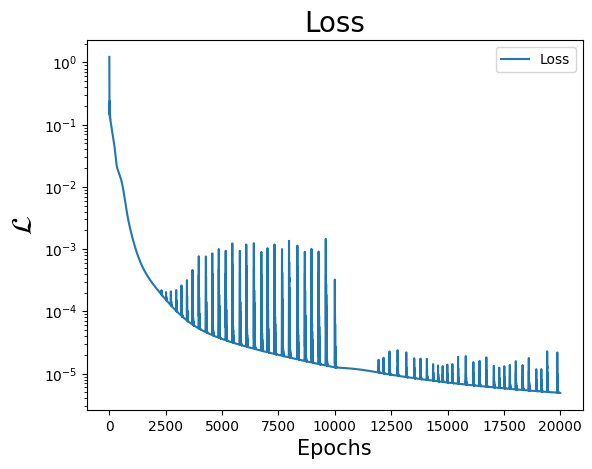

In [10]:
# Grafica Loss
plt.title('Loss', fontsize = 20)
plt.plot(pinn.loss_history['Loss'], label = 'Loss')
plt.xlabel('Epochs', fontsize = 15)
plt.ylabel('$\\mathcal{L}$', fontsize = 20)
plt.legend()
plt.yscale('log')
plt.show()

In [8]:
def exact_solution(x0, a, t):
    return x0 * torch.exp(-a*t)

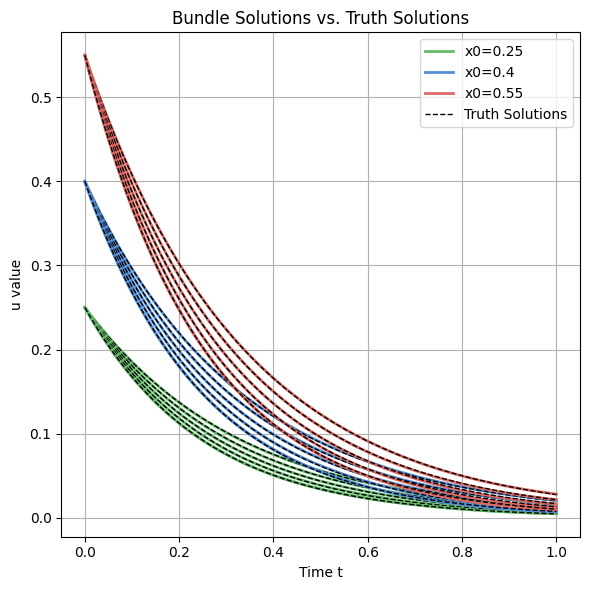

Average MSE:  1.6986152e-07
Relative mean absolute difference:  0.0025577142


In [9]:
colors = ['#66bb6a', '#558ed5', '#dd6a63', '#dcd0ff', '#ffa726', '#8c5eff', '#f44336', '#00bcd4', '#ffc107', '#9c27b0']
exact_solutions = [[],[],[]]
predictions = [[],[],[]]

plt.figure(figsize=(6, 6))

for index, j in enumerate(np.linspace(x_0_min+0.05, x_0_max-0.05, 3)):
    for i in np.linspace(a_min+1, a_max-1, 5):
        t_vals = torch.linspace(0,1,100).view(-1,1)
        a_tensor = i * torch.ones_like(t_vals)
        x_0_tensor = j * torch.ones_like(t_vals)

        u_pred = pinn(t_vals, a_tensor, x_0_tensor)
        u_exact = exact_solution(x_0_tensor, a_tensor, t_vals)
        u_pred = u_pred.detach().numpy()
        u_exact = u_exact.detach().numpy()
        exact_solutions[index].append(u_exact)
        predictions[index].append(u_pred)
        plt.plot(t_vals, u_pred, lw=2, c=colors[index])
        plt.plot(t_vals, u_exact, '--', c='black', lw=1)


plt.plot(t_vals, predictions[0][-1], lw=2, label=f'x0={x_0_min+0.05}', c=colors[0]);
plt.plot(t_vals, predictions[1][-1], lw=2, label=f'x0={(x_0_min + x_0_max)/2}', c=colors[1]);
plt.plot(t_vals, predictions[2][-1], lw=2, label=f'x0={round(x_0_max-0.05, 2)}', c=colors[2]);
plt.plot(t_vals, exact_solutions[0][-1], '--', c='black', lw=1, label='Truth Solutions');
plt.plot(t_vals, exact_solutions[1][-1], '--', c='black', lw=1);
plt.plot(t_vals, exact_solutions[2][-1], '--', c='black', lw=1);
plt.xlabel("Time t");
plt.ylabel('u value');
plt.title("Bundle Solutions vs. Truth Solutions");

plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

##compute the avg MSE
predictions  = np.array(predictions)
exact_solutions = np.array(exact_solutions)
MSE = ((predictions - exact_solutions)**2).mean()
RAMD = abs(predictions - exact_solutions).mean()/abs(exact_solutions).mean()
print("Average MSE: ", MSE)
print("Relative mean absolute difference: ", RAMD)
